# Pricing American Options using the Heston model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pickle import dump, load
from Hestonmodel import HestonObjFun, Hestonprice
from BSmodel import BS, BSObjFun
from Calibration import calibrate, implied_vol, plot_prices, parametertable
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

Known option parameters

In [2]:

N = 252                        # number of time steps in simulation
O = 9                          # number of strike prices

r = 0.1                        # risk-free rate
d = 0.02                       # dividend yield
S0 = 100.0                     # asset price
K = np.linspace(85,115,O+1)    # strike price
T = np.linspace(1e-100,1,N+1)  # time in years
call = False                   # call or put
knownpars = [r,d,S0,K,T,call]  # Common parameters throughout the code


Simulation parameters

In [369]:
GP = lambda K: [(0, 2.5*K), (0, 0.5), (0, 1), 99,99, 5300]           # Grid parameters
sigma = 0.1                                                         # Black-Scholes parameter
                  #  kappa    theta   sigmav    rho       v0
Hestonpars      = [    3   ,  0.04  , 0.0625 ,  0.7   ,  0.01  ]    # Heston parameters     
Hestonfixedpars = [    0   ,sigma**2,   0    ,   0    ,sigma**2]    # Heston parameters with constant volatility


Simulate the $3$ markets.

In [370]:
np.random.seed(5)
MktPrice = {'BS': BS(sigma, knownpars), 
            'Heston': Hestonprice(Hestonpars, knownpars, GP=GP, uniform=False), 
            'Hestonfixed': Hestonprice(Hestonfixedpars, knownpars, GP=GP, uniform=False)}

In [11]:
#Save params
with open("Data\\Mktprice.pkl", "wb") as file:
    dump(MktPrice, file)


In [273]:
#Load params
with open("Data\\Mktprice.pkl", "rb") as file:
    MktPrice = load(file)

Plot the markets.

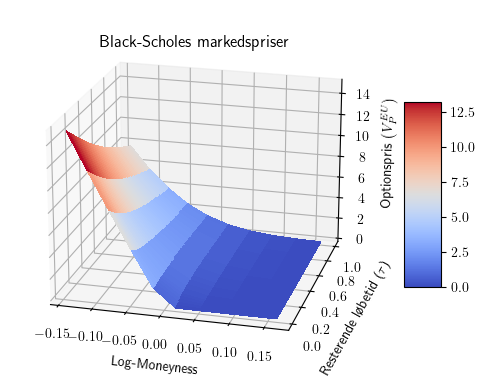

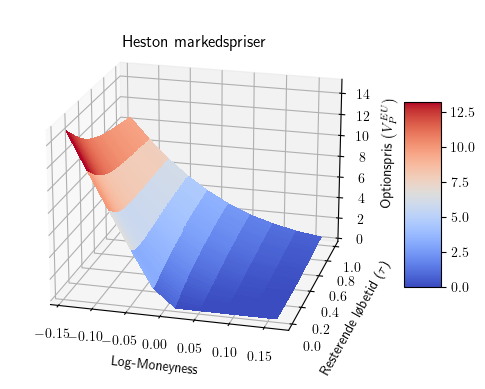

In [239]:
plot_prices(K,S0,T,MktPrice['BS'], title = 'Black-Scholes markedspriser', y = 0.9)
plot_prices(K,S0,T,MktPrice['Heston'], title = 'Heston markedspriser', y = 0.9)
plt.show()

The absolute difference between BS and Hestonfixed reveals the magnitude of discretization errors.

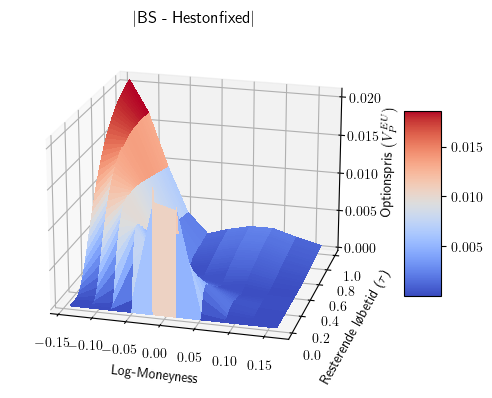

MSE: 5.394522885501616e-05, MAPE: 253836.89296708195


In [371]:
plot_prices(K,S0,T,abs(MktPrice['BS'] - MktPrice['Hestonfixed']), title = r'$|$BS - Hestonfixed$|$')
plt.show()
mse = MSE(MktPrice['BS'], MktPrice['Hestonfixed'])
mape = MAPE(MktPrice['BS'], MktPrice['Hestonfixed'])
print(f'MSE: {mse}, MAPE: {mape}')

Difference between Black-Scholes and Heston

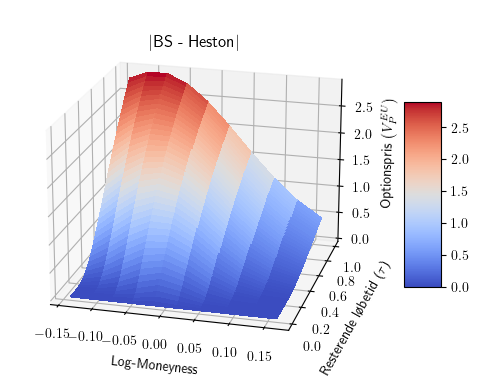

MSE: 1.618305238142058, MAPE: 110.63909336523548


In [206]:
plot_prices(K,S0,T,abs(MktPrice['BS'] - MktPrice['Heston']), title = r'$|$BS - Heston$|$', y=0.9)
plt.show()
mse = MSE(MktPrice['BS'], MktPrice['Heston'])
mape = MAPE(MktPrice['BS'], MktPrice['Heston'])
print(f'MSE: {mse}, MAPE: {mape}')

## Calibration

Initializing models, markets, objective functions, start parameters, bounds and options for calibration in a $3\times2$ grid.

In [167]:
#sigma = 0.1                                                         # Black-Scholes parameter
                  #  kappa    theta   sigmav    rho       v0
#Hestonpars      = [    3   ,  0.04  , 0.0625 ,  0.7   ,  0.01  ]    # Heston parameters     
#Hestonfixedpars = [    0   ,sigma**2,   0    ,   0    ,sigma**2]    # Heston parameters with constant volatility
GP = lambda K: [(0, 2.5*K), (0, 0.5), (0, 1), 99, 29, 5300]

#GP = lambda K: [(0, 2.5*K), (0, 0.5), (0, 1), 21, 9, 260]
models,markets = np.meshgrid(["BS", "Heston"],["BS", "Heston", "Hestonfixed"])
objfun = np.tile([BSObjFun,HestonObjFun],(3,1))

boundsBS = [(1e-3,2)]
boundsHeston = [(0,10),(0,2),(0,2),(-.99,.99),(0,0.499)]

startBS = {'sigma':0.15}
startHeston = {'kappa': 1, 'theta': 0.02, 'sigmav': 0.02, 'rho':0.6, 'v0':0}
start = np.tile([startBS,startHeston],(3,1))



bounds = np.array(np.tile([boundsBS,boundsHeston],(3,1)), dtype=object)
options = {'maxiter': 10000}

c:\Users\Oliver\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\shape_base.py:1270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = _nx.array(A, copy=False, subok=True, ndmin=d)


Calibrating the parameters (no need to run, parameters are saved)

In [37]:
params = np.zeros(models.shape, dtype=object)
mse = np.zeros(models.shape)
for i, j in np.ndindex(models.shape):
    params[i,j], mse[i,j] = calibrate(bounds[i,j],start[i,j],objfun[i,j], knownpars, MktPrice, model=models[i,j], market=markets[i,j],options=options, uniform=False, American=False, GP=GP)

Market: BS 
Model: BS
-------------------------------------------------------- 

   MSE     sigma  
-------------------------------------------------------- 

 0.9407    0.15   
 1.2673   0.1575  
 0.6666   0.1425  
 0.4428    0.135  
 0.1382    0.12   
 0.0082    0.105  
 0.1798    0.075  
 0.0309    0.09   
 0.1382    0.12   
  0.002   0.0975  
 0.0309    0.09   
 0.0005   0.1012  
 0.0082    0.105  
 0.0001   0.0994  
  0.002   0.0975  
   0.0    0.1003  
 0.0005   0.1012  
   0.0    0.0998  
 0.0001   0.0994  
   0.0    0.1001  
   0.0    0.1003  
   0.0      0.1   
   0.0    0.0998  
   0.0      0.1   
-------------------------------------------------------- 

Market: BS 
Model: Heston
-------------------------------------------------------- 

   MSE     kappa    theta   sigmav     rho      v0    
-------------------------------------------------------- 

 0.2084     1.0     0.02     0.02      0.6      0.0   
 0.1908    1.05     0.02     0.02      0.6      0.0   
 0.1864     1.0  

In [41]:
#Save params
with open("Data\\calib.pkl", "wb") as file:
    dump((params,mse), file)

In [340]:
#Load params
with open("Data\\calib.pkl", "rb") as file:
    params,mse = load(file)

In [321]:
print(parametertable(params))
print(parametertable(mse,True))

                 sigma     kappa       theta     sigmav           rho         v0
-----------  ---------  --------  ----------  ---------  ------------  ---------
BS           0.1        2.59037   0.00991914  0.001      -0.715953     0.01002
Heston       0.163125   2.81298   0.0402623   0.001      -0.99         0.0106827
Hestonfixed  0.0998438  0.989985  0.0100083   0.0534949   0.000696221  0.0100047
                      BS       Heston
-----------  -----------  -----------
BS           0            1.22325e-05
Heston       0.0543151    0.00217408
Hestonfixed  5.14891e-05  1.78904e-07


The parameters are quite different when comparing with the expected parameters:

In [322]:
expectedparams = params.copy()
expectedparams[0,0] = np.array([sigma])
# 1,0 not known so param estimate is best
expectedparams[2,0] = np.array([sigma])
expectedparams[0,1] = np.array(Hestonfixedpars)
expectedparams[1,1] = np.array(Hestonpars)
expectedparams[2,1] = np.array(Hestonfixedpars)

print("parameters")
print(parametertable(params),"\n")
print("Expected parameters")
print(parametertable(expectedparams),"\n")

print("Parameter error")
print(parametertable(abs(expectedparams - params)),"\n")


parameters
                 sigma     kappa       theta     sigmav           rho         v0
-----------  ---------  --------  ----------  ---------  ------------  ---------
BS           0.1        2.59037   0.00991914  0.001      -0.715953     0.01002
Heston       0.163125   2.81298   0.0402623   0.001      -0.99         0.0106827
Hestonfixed  0.0998438  0.989985  0.0100083   0.0534949   0.000696221  0.0100047 

Expected parameters
                sigma    kappa    theta    sigmav    rho    v0
-----------  --------  -------  -------  --------  -----  ----
BS           0.1             0     0.01    0         0    0.01
Heston       0.163125        3     0.04    0.0625    0.7  0.01
Hestonfixed  0.1             0     0.01    0         0    0.01 

Parameter error
                  sigma     kappa        theta     sigmav          rho           v0
-----------  ----------  --------  -----------  ---------  -----------  -----------
BS           0           2.59037   8.08573e-05  0.001      0.71

The expected MSE can be found as follows:

In [338]:
GP = lambda K: [(0, 2.5*K), (0, 0.5), (0, 1), 99, 99, 5300]
expectedmse = mse.copy()
for i, j in np.ndindex(models.shape):
    expectedmse[i,j] = objfun[i,j](expectedparams[i,j],knownpars,MktPrice[markets[i,j]], uniform=False, American=False, GP=GP)

   0.0      0.1   
 0.0001     0.0     0.01      0.0      0.0     0.01   
 0.0519   0.1631  
   0.0      3.0     0.04    0.0625     0.7     0.01   
   0.0      0.1   
   0.0      0.0     0.01      0.0      0.0     0.01   


The MSE's for the calibrated parameters are larger than expected. 
That is, there exists another set of parameters that result in smaller values in the objective function.
Therefore, it must be a local minimum.

In [341]:
print("MSE using calibrated parameters")
print(parametertable(mse,True))
print("Expected MSE")
print(parametertable(expectedmse,True))

MSE using calibrated parameters
                      BS       Heston
-----------  -----------  -----------
BS           0            1.22325e-05
Heston       0.0543151    0.00217408
Hestonfixed  5.14891e-05  1.78904e-07
Expected MSE
                      BS       Heston
-----------  -----------  -----------
BS           0            5.39452e-05
Heston       0.0518603    2.0412e-05
Hestonfixed  8.17294e-06  2.18045e-05


To help steer towards the global minimum we choose start parameters very close to the expected. This does however not result in exactly the same parameters due to discretization errors. In fact, it is possible that the calibration procedure results in MSE's lower than expected.

### Calibration round 2

In [85]:
start = dict(zip(np.array(["kappa","theta","sigmav","rho","v0"]),np.array(Hestonpars)+1e-3))
params[1,1], mse[1,1] = calibrate(bounds[1,1],start,objfun[1,1], knownpars, MktPrice, model=models[1,1], market=markets[1,1],options=options, uniform=False, American = False, GP=GP)


Market: Heston 
Model: Heston
-------------------------------------------------------- 

   MSE     kappa    theta   sigmav     rho      v0    
-------------------------------------------------------- 

 0.0043    3.001    0.041   0.0635    0.701    0.011  
 0.0085    3.151    0.041   0.0635    0.701    0.011  
 0.0192    3.001   0.0431   0.0635    0.701    0.011  
 0.0043    3.001    0.041   0.0667    0.701    0.011  
 0.0043    3.001    0.041   0.0635    0.736    0.011  
 0.0067    3.001    0.041   0.0635    0.701   0.0116  
 0.0005    3.061    0.039   0.0648    0.715   0.0112  
 0.0047    3.091   0.0369   0.0654    0.722   0.0113  
 0.0007    2.875   0.0402   0.0653   0.7206   0.0113  
 0.0002   2.9746   0.0399    0.066   0.7285   0.0107  
 0.0009   2.9614   0.0393   0.0672   0.7422   0.0102  
 0.0004    2.964   0.0394    0.067   0.7395   0.0111  
 0.0009   2.9492   0.0387   0.0684   0.7058   0.0111  
  0.004   2.9285   0.0378   0.0659   0.7428   0.0111  
 0.0012   2.9467   0.0386  

In [ ]:
#Save params
with open("Data\\calib2.pkl", "wb") as file:
    dump((params,mse), file)

In [342]:
#Load params
with open("Data\\calib2.pkl", "rb") as file:
    params,mse = load(file)


In [350]:
print("Calibrated")
print(parametertable(params))
print(parametertable(mse,mse=True))
print("\nExpected")
print(parametertable(expectedparams))
print(parametertable(expectedmse,mse=True))
print("\nDifference")
print(parametertable(params - expectedparams))
print(parametertable(mse - expectedmse,mse=True))


Calibrated
                 sigma     kappa       theta     sigmav           rho          v0
-----------  ---------  --------  ----------  ---------  ------------  ----------
BS           0.1        2.59037   0.00991914  0.001      -0.715953     0.01002
Heston       0.163125   3.03993   0.0398269   0.0414472   0.99         0.00987891
Hestonfixed  0.0998438  0.989985  0.0100083   0.0534949   0.000696221  0.0100047
                      BS       Heston
-----------  -----------  -----------
BS           0            1.22325e-05
Heston       0.0543151    3.921e-06
Hestonfixed  5.14891e-05  1.78904e-07

Expected
                sigma    kappa    theta    sigmav    rho    v0
-----------  --------  -------  -------  --------  -----  ----
BS           0.1             0     0.01    0         0    0.01
Heston       0.163125        3     0.04    0.0625    0.7  0.01
Hestonfixed  0.1             0     0.01    0         0    0.01
                      BS       Heston
-----------  -----------  ------

## Pricing options

In [160]:
def pricing(params, GP=None):
    priceam = np.zeros((3,2,10,253))
    priceeu = np.zeros((3,2,10,253))

    pricefun = np.tile([BS,Hestonprice],(3,1))

    for i,j in np.ndindex(models.shape):
        priceam[i,j] = pricefun[i,j](params[i,j],knownpars, uniform=False, American=True, GP=GP)
        priceeu[i,j] = pricefun[i,j](params[i,j],knownpars, uniform=False,American=False, GP=GP)
    return [priceam, priceeu]

In [161]:
GP = lambda K: [(0, 2.5*K), (0, 0.5), (0, 1), 99, 29, 5300]
priceam, priceeu = pricing(params, GP=GP)
EEP = priceam - priceeu

Lambda 0.45351473922902497 (stable)
Lambda 0.47070245021489476 (stable)
Lambda 0.45344715385760087 (stable)


In [162]:
expectedpriceam, expectedpriceeu = pricing(expectedparams, GP=GP)
expectedEEP = expectedpriceam - expectedpriceeu

Lambda 0.45351473922902497 (stable)
Lambda 0.47070245021489476 (stable)
Lambda 0.45351473922902497 (stable)


In [ ]:
#save
with open("Data\\prices.pkl", "wb") as file:
    dump((priceam, priceeu, EEP, expectedpriceam, expectedpriceeu, expectedEEP), file)

In [ ]:
#load
with open("Data\\prices.pkl", "rb") as file:
    priceam, priceeu, EEP, expectedpriceam, expectedpriceeu, expectedEEP = load(file)

### Early exercise premium

In [163]:
EEPmse = np.zeros(models.shape)
for i,j in np.ndindex(models.shape):
    EEPmse[i,j] = MSE(EEP[i,j],expectedEEP[i,j])
print("MSE (EEP vs expected)")
print(parametertable(EEPmse,True))

MSE (EEP vs expected)
                      BS       Heston
-----------  -----------  -----------
BS           0            8.55359e-06
Heston       0            6.98274e-06
Hestonfixed  4.81887e-06  1.51221e-05


EEP plots

EEP


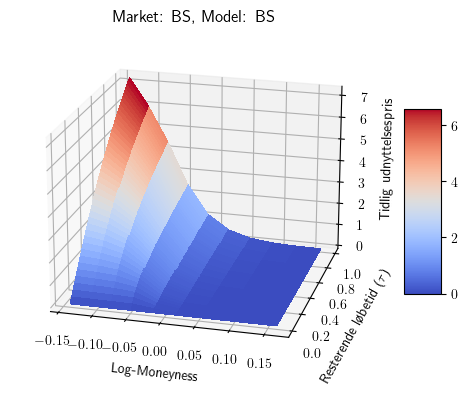

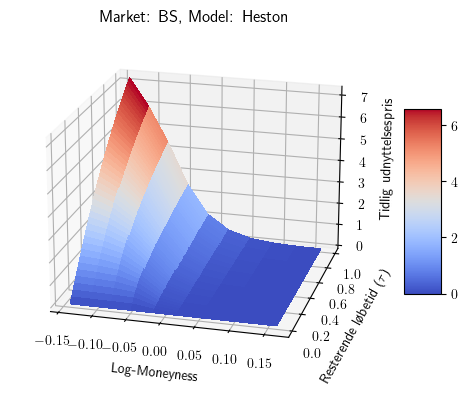

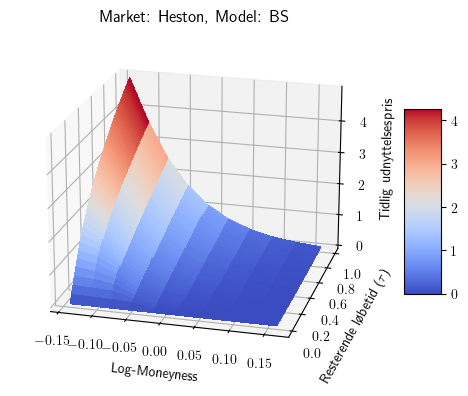

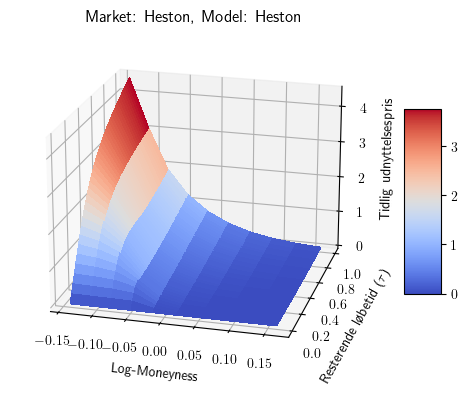

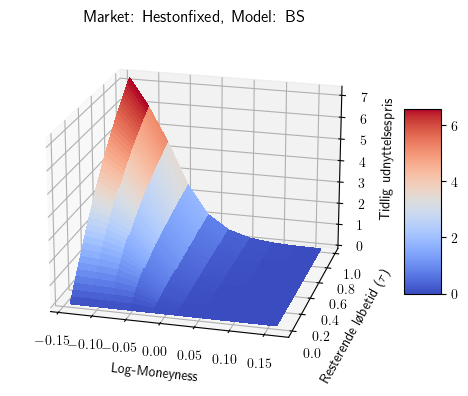

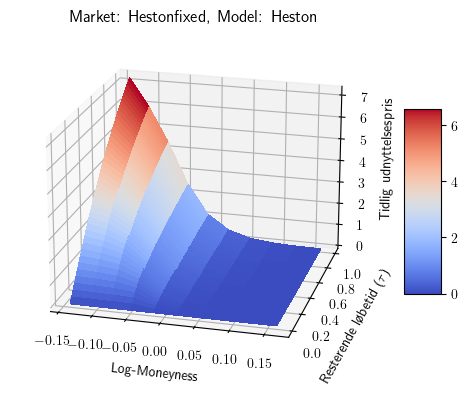

Error in terms of expected EEP


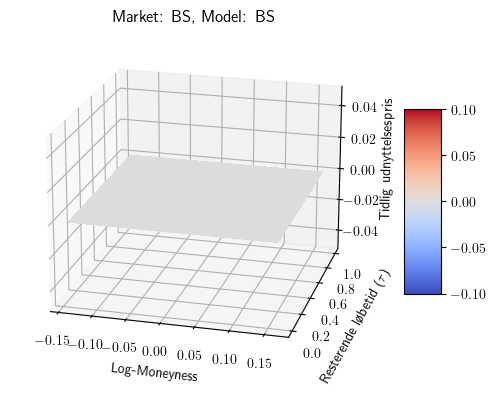

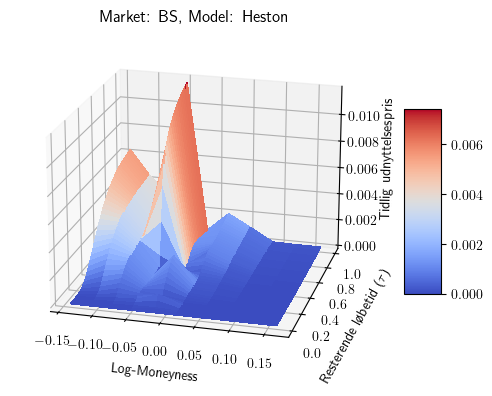

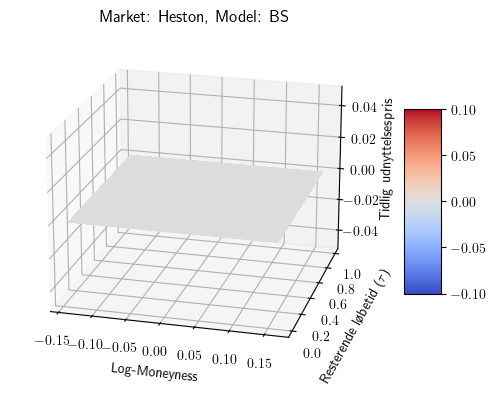

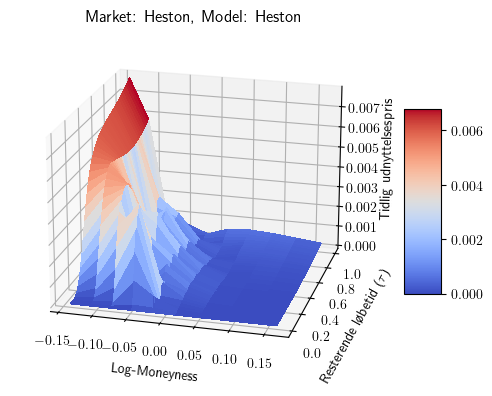

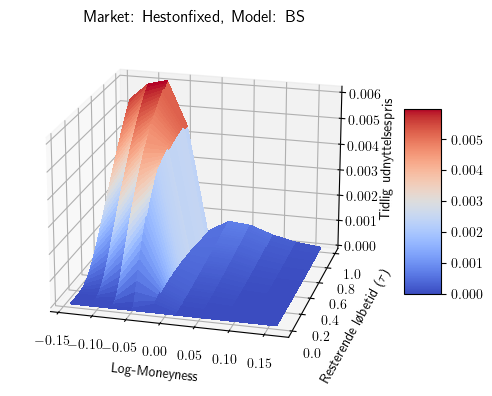

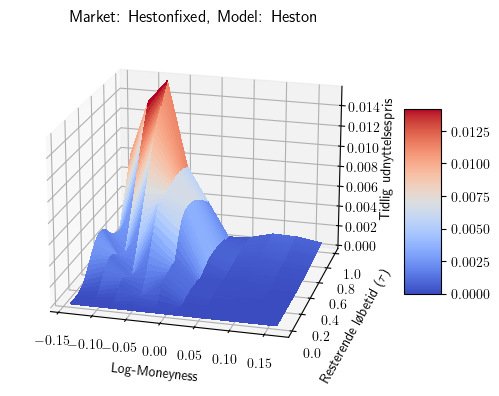

In [165]:
print("EEP")
for i,j in np.ndindex(models.shape):
    plot_prices(K,S0,T,EEP[i,j], title=f'Market: {markets[i,j]}, Model: {models[i,j]}', type="EEP", azim=-75)
plt.show()

print("Error in terms of expected EEP")
for i,j in np.ndindex(models.shape):
    plot_prices(K,S0,T,abs(EEP[i,j] - expectedEEP[i,j]), title=f'Market: {markets[i,j]}, Model: {models[i,j]}', type="EEP", azim=-75)
plt.show()


Early exercise MSE

In [170]:
EEMSE = np.zeros((models.shape))
for i,j in np.ndindex(models.shape):
    EEMSE[i,j] = MSE(EEP[i,j],expectedEEP[i,j])

print(parametertable(EEMSE,mse=True))


                      BS       Heston
-----------  -----------  -----------
BS           0            8.55359e-06
Heston       0            6.98274e-06
Hestonfixed  4.81887e-06  1.51221e-05


## Implied volatility <br>
All surfaces are with respect to the heston model.

### European IV

In [194]:
IVeu = np.zeros((3,10,253))
for i in range(3):
    IVeu[i] = implied_vol(priceeu[i,1], knownpars, eps = 1e-3, American=False)

expectedIVeu = np.zeros((3,10,253))
for i in range(3):
    expectedIVeu[i] = implied_vol(expectedpriceeu[i,1], knownpars, eps = 1e-3, American=False)

In [279]:
#markedsvolatilitet 
# GP = lambda K: [(0, 2.5*K), (0, 0.5), (0, 1), 199, 199, 21000]
markedIVeu = np.zeros((3,10,253))
markedIVeu = implied_vol(MktPrice["Heston"], knownpars, eps = 1e-3, American=False)

In [394]:
# Save
with open("Data\\IVeu.pkl", "wb") as file:
    dump((IVeu, expectedIVeu, markedIVeu), file)


In [282]:
# Load
with open("Data\\IVeu.pkl", "rb") as file:
    IVeu,expectedIVeu,markedIVeu = load(file)



**Plots**

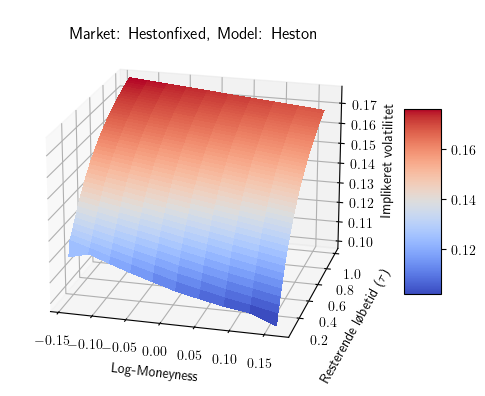

In [382]:
j = 14
plot_prices(K,S0,T[j:],markedIVeu[:,j:], title="", subtitle=f"Market: {markets[i,1]}, Model: Heston", type="IV")


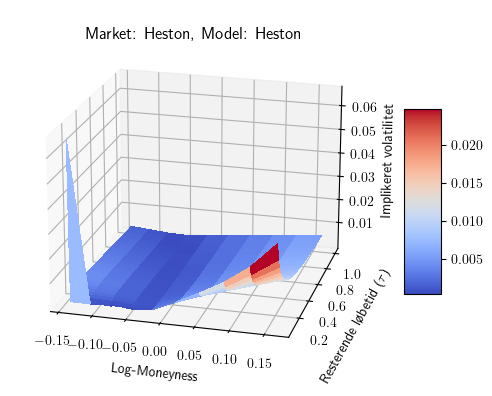

In [383]:
j = 14
diff = abs(markedIVeu - IVeu[1])
plot_prices(K,S0,T[j:],diff[:,j:], title="", subtitle=f"Market: Heston, Model: Heston", type="IV")
plt.show()

In [372]:
MSE(markedIVeu,IVeu[1])

8.043414700303807e-05

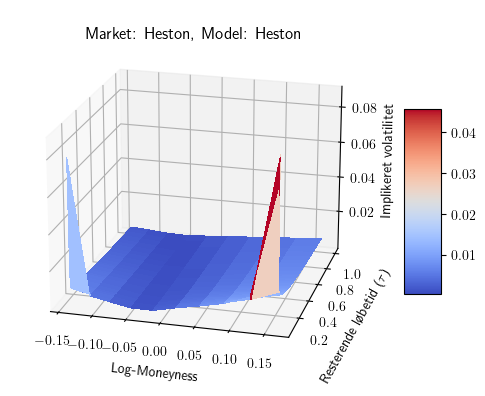

In [390]:
j = 14
diff = abs(expectedIVeu[1] - IVeu[1])
plot_prices(K,S0,T[j:],diff[:,j:], title="", subtitle=f"Market: Heston, Model: Heston", type="IV")
plt.show()

In [391]:
MSE(expectedIVeu[1],IVeu[1])

8.455734490462927e-05

Calibrated



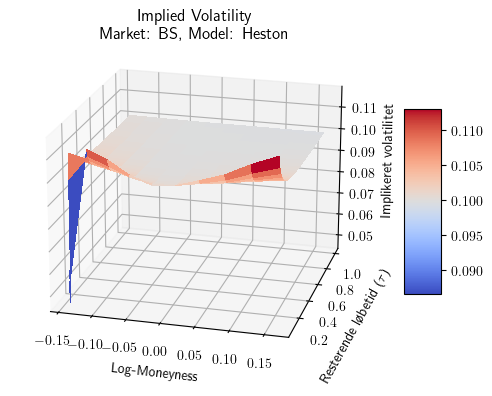

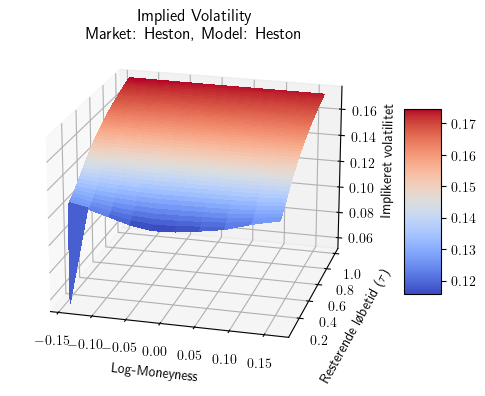

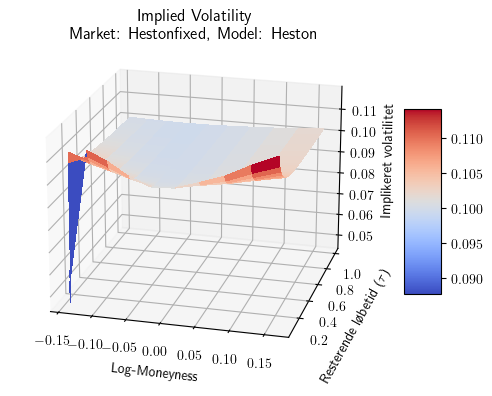

Expected



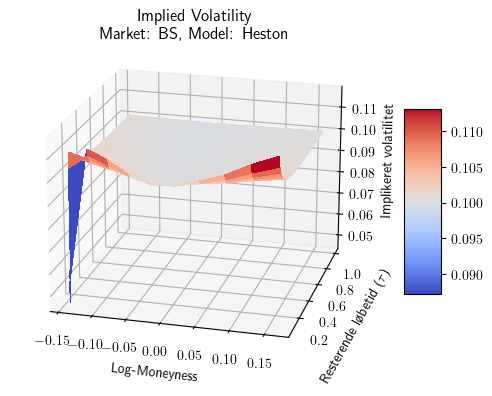

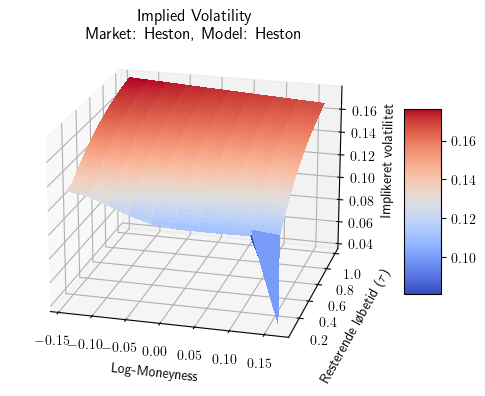

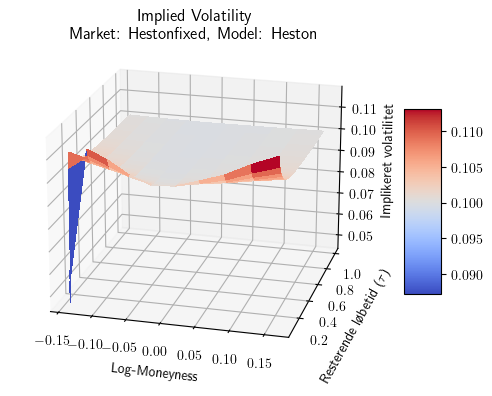

Error / difference


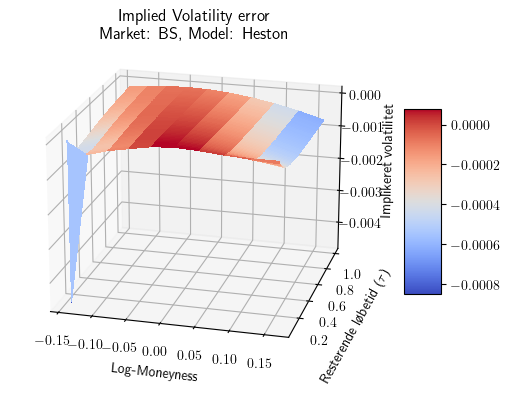

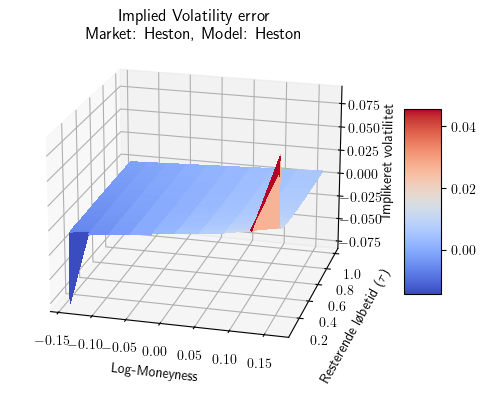

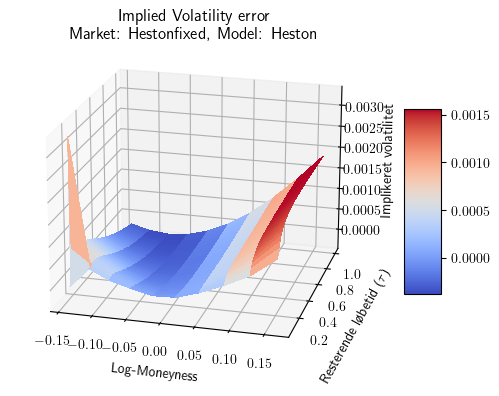

In [292]:
j = 14
print('Calibrated\n')
for i in range(3):
    plot_prices(K,S0,T[j:],IVeu[i][:,j:], title="Implied Volatility", subtitle=f"Market: {markets[i,1]}, Model: Heston", type="IV")
plt.show()

print('Expected\n')
for i in range(3):
    plot_prices(K,S0,T[j:],expectedIVeu[i][:,j:], title="Implied Volatility", subtitle=f"Market: {markets[i,1]}, Model: Heston", type="IV")
plt.show()


print("Error / difference")
for i in range(3):
    plot_prices(K,S0,T[j:],(IVeu - expectedIVeu)[i][:,j:], title="Implied Volatility error", subtitle=f"Market: {markets[i,1]}, Model: Heston", type="IV")
plt.show()

### American IV

In [355]:
t = slice(1,50)
modelprice_am_14 = priceam[1,1,:,t]

IVam = np.zeros(modelprice_am_14.shape)
IVam = implied_vol(modelprice_am_14, [*knownpars[:4],T[t],False], eps = 1e-2,v_max=1600,m=1600, American=True)

Lambda 0.410308520249422 (stable)
Lambda 0.4414812731761836 (stable)
Lambda 0.45183493557487475 (stable)
Lambda 0.4565834647185514 (stable)
Lambda 0.4590771648896344 (stable)
Lambda 0.4604800980601848 (stable)
Lambda 0.4613000803772872 (stable)
Lambda 0.4617900661668282 (stable)
Lambda 0.46208674091099494 (stable)
Lambda 0.46226780442319093 (stable)
Lambda 0.46237884600509416 (stable)
Lambda 0.46244714741661264 (stable)
Lambda 0.46248923619676924 (stable)
Lambda 0.46251520137211893 (stable)
Lambda 0.4625312307745296 (stable)
Lambda 0.4625411306399924 (stable)
Lambda 0.46254724647908235 (stable)
Lambda 0.46255102527748215 (stable)
Lambda 0.4625533603222416 (stable)
Lambda 0.46255480331373494 (stable)
Lambda 0.46255569507594135 (stable)
Lambda 0.462556246194066 (stable)
Lambda 0.46255658679569067 (stable)
Lambda 0.4625567972959742 (stable)
Lambda 0.46255692739112136 (stable)
Lambda 0.462557007793892 (stable)
Lambda 0.4625570671728123 (stable)
Lambda 0.410308520249422 (stable)
Lambda 0.44

In [393]:
#save
with open("Data\\IVam.pkl", "wb") as file:
    dump(IVam, file)

In [ ]:
#load
with open("Data\\IVam.pkl", "rb") as file:
    IVam = load(file)

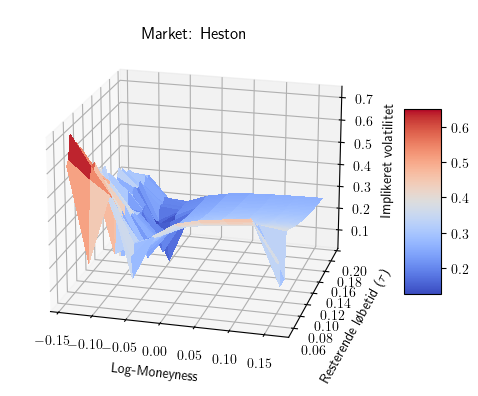

In [381]:

j = 14
#plt.plot(np.log(S0/K),IVam[:,j-1])
plot_prices(K,S0,T[t][j-1:],IVam[:,j-1:], title="", subtitle=f"Market: {markets[1,1]}", type="IV")


In [368]:
MSE(priceeu[0,1],priceeu[2,1])

2.378355987772541e-05

In [385]:
GP = lambda K: [(0, 2.5*K), (0, 0.5), (0, 1), 199, 199, 21000]
marketpriceam = Hestonprice(Hestonpars, knownpars, GP=GP, uniform=False, American = True)
GP = lambda K: [(0, 2.5*K), (0, 0.5), (0, 1), 99, 99, 5300]

In [387]:
t = slice(1,50)

marketprice_am_14 = marketpriceam[:,t]

marketIVam = np.zeros(marketprice_am_14.shape)
marketIVam = implied_vol(marketprice_am_14, [*knownpars[:4],T[t],False], eps = 1e-2,v_max=1600,m=1600, American=True)

Lambda 0.410308520249422 (stable)
Lambda 0.4414812731761836 (stable)
Lambda 0.45183493557487475 (stable)
Lambda 0.4565834647185514 (stable)
Lambda 0.4590771648896344 (stable)
Lambda 0.4604800980601848 (stable)
Lambda 0.4613000803772872 (stable)
Lambda 0.4617900661668282 (stable)
Lambda 0.46208674091099494 (stable)
Lambda 0.46226780442319093 (stable)
Lambda 0.46237884600509416 (stable)
Lambda 0.46244714741661264 (stable)
Lambda 0.46248923619676924 (stable)
Lambda 0.46251520137211893 (stable)
Lambda 0.4625312307745296 (stable)
Lambda 0.4625411306399924 (stable)
Lambda 0.46254724647908235 (stable)
Lambda 0.46255102527748215 (stable)
Lambda 0.4625533603222416 (stable)
Lambda 0.46255480331373494 (stable)
Lambda 0.46255569507594135 (stable)
Lambda 0.462556246194066 (stable)
Lambda 0.46255658679569067 (stable)
Lambda 0.4625567972959742 (stable)
Lambda 0.46255692739112136 (stable)
Lambda 0.462557007793892 (stable)
Lambda 0.4625570671728123 (stable)
Lambda 0.410308520249422 (stable)
Lambda 0.44

In [392]:
#save
with open("Data\\marketIVam.pkl", "wb") as file:
    dump(marketIVam, file)

In [ ]:
#load
with open("Data\\marketIVam.pkl", "rb") as file:
    marketIVam = load(file)

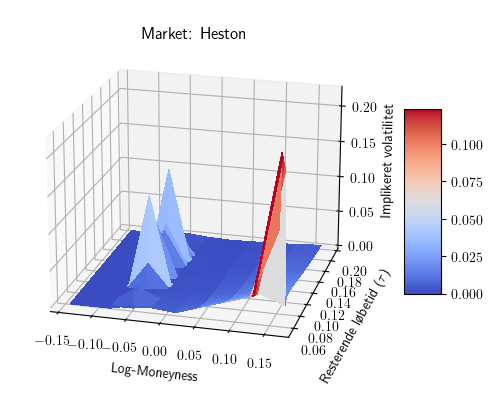

In [388]:
j = 14
#plt.plot(np.log(S0/K),IVam[:,j-1])
plot_prices(K,S0,T[t][j-1:],abs(marketIVam - IVam)[:,j-1:], title="", subtitle=f"Market: {markets[1,1]}", type="IV")

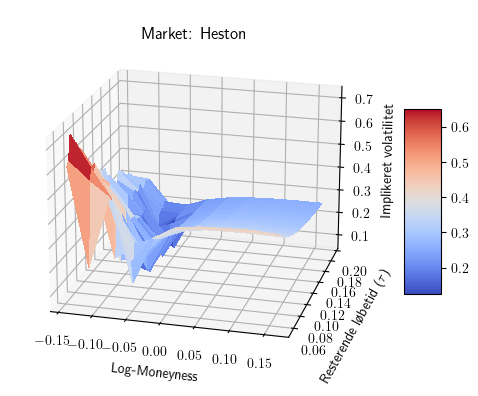

In [389]:
j = 14
#plt.plot(np.log(S0/K),IVam[:,j-1])
plot_prices(K,S0,T[t][j-1:],abs(marketIVam)[:,j-1:], title="", subtitle=f"Market: {markets[1,1]}", type="IV")